In [1]:
import warnings
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

# MNIST

In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of machine learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.
Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from OpenML.org:

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

The `fetch_openml()` function is a bit unusual since by default it returns the inputs as a Pandas DataFrame and the labels as a Pandas Series (unless the dataset is sparse). But the MNIST dataset contains images, and DataFrames aren’t ideal for that, so it’s preferable to set as_frame=False to get the data as NumPy arrays instead. Let’s look at these arrays:

In [3]:
X, y = mnist.data, mnist.target

print(X)
print(X.shape)
print(y)
print(y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset.

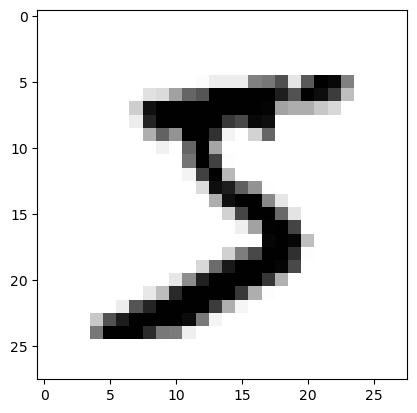

In [4]:
plt.imshow(X[0].reshape(28, 28), cmap="binary")

This looks like a 5, and indeed that’s what the label tells us:

In [5]:
y[0]

'5'

The MNIST dataset returned by fetch_openml() is actually already split into
a training set (the first 60,000 images) and a test set (the last 10,000 images:

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. 
This “5-detector” will be an example of a binary classifier, capable
of distinguishing between just two classes, 5 and non-5. First we’ll create the target vectors for this classification task:

In [7]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a stochastic gradient
descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s SGDClassifier
class. This classifier is capable of handling very large datasets efficiently. This is in
part because SGD deals with training instances independently, one at a time, which
also makes SGD well suited for online learning, as you will see later. Let’s create an
SGDClassifier and train it on the whole training set:

In [8]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [9]:
sgd_clf.predict([X[0]])

array([ True])

Observe predict takes as input an array or list of instances to predict. 

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, just as you did for regression. Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold crossvalidation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation:

In [10]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy
classifier that just classifies every single image in the most frequent class, which in
this case is the negative class (i.e., non 5):

In [11]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the
performance of a classifier is to look at the confusion matrix (CM).

## Confusion Matrices

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs k-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (by “clean” I mean “out-of-sample”: the model makes predictions on data that it never saw during training).

Now you are ready to get the confusion matrix using the confusion_matrix()
function. Just pass it the target classes (`y_train_5`) and the predicted classes
(`y_train_pred`):

In [13]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

There is a problem with the book. 
The order of classes in the above confusion matrix is wrong. The "not-5" class is considered to be the "positive" class. 

In scikit-learn, the confusion_matrix function labels the classes in ascending order by class label. So, False (or 0) comes before True (or 1). 

If you want to flip the order of the classes, you can do this by using the `labels` parameter of the confusion_matrix function.

In [14]:
cm = confusion_matrix(y_train_5, y_train_pred, labels=[True, False])
cm

array([[ 3530,  1891],
       [  687, 53892]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the
negative class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives, also
called type I errors). The second row considers the images of 5s (the positive class):
1,891 were wrongly classified as non-5s (false negatives, also called type II errors),
while the remaining 3,530 were correctly classified as 5s (true positives). A perfect
classifier would only have true positives and true negatives, so its confusion matrix
would have nonzero values only on its main diagonal (top left to bottom right):

In [15]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions, labels=[True, False])

array([[ 5421,     0],
       [    0, 54579]], dtype=int64)

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the precision of the classifier
$$ 
\text{precision} = \frac{TP}{TP+FP}
$$
$TP$ is the number of true positives, $FP$ is the number of false positives. Both can be extracted from the confusion matrix.

A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about. If this one prediction is correct, then the classifier has 100% precision (precision = 1/1 = 100%). Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance. So, precision is typically used along with another metric named recall, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier 
$$
 \text{recall} = \frac{TP}{TP + FN}
$$
$FN$ is, of course, the number of false negatives.

# Precision and Recall

Here the labels are correctly considered. No need to add `labels=[True, False]`.

In [16]:
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy.
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover,
it only detects 65.1% of the 5s.


It is often convenient to combine precision and recall into a single metric called the
F1 score, especially when you need a single metric to compare two classifiers. The
F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the
regular mean treats all values equally, the harmonic mean gives much more weight to
low values. As a result, the classifier will only get a high F1 score if both recall and
precision are high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}
$$

To compute the F1 score, simply call the `f1_score()` function:

In [18]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. 

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a
classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 

On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has
30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

To understand this trade-off, let’s look at how the SGDClassifier makes
its classification decisions. For each instance, it computes a score based
on a decision function. If that score is greater than a threshold, it assigns
the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give
you access to the decision scores that it uses to make predictions.
Instead of calling the classifier’s predict() method, you can call its
decision_function() method, which returns a score for each
instance, and then use any threshold you want to make predictions based
on those scores:

In [19]:
y_scores = sgd_clf.decision_function([X[0]])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


The `SGDClassifier` uses a threshold equal to 0, so the preceding code returns the
same result as the `predict()` method (i.e., `True`). Let’s raise the threshold:

In [20]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the
`cross_val_predict()` function to get the scores of all instances in the
training set, but this time specify that you want to return decision scores
instead of predictions:

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                             cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the `precision_recall_curve()` function to
compute precision and recall for all possible thresholds (the function adds
a last precision of 0 and a last recall of 1, corresponding to an infinite
threshold):

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
thresholds.shape

(60000,)

**Question**: Why do we have 60,000 thresholds.

Finally, use Matplotlib to plot precision and recall as functions of the
threshold value. Let’s show the threshold of 3,000 we selected:

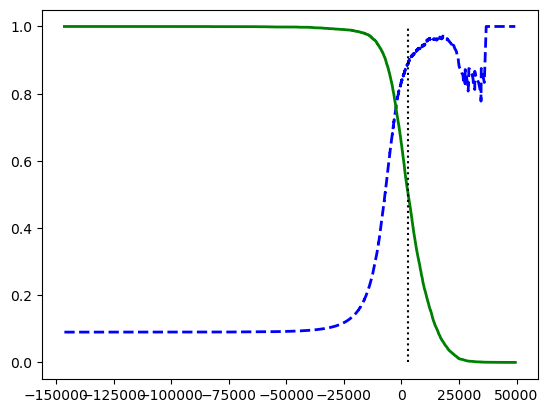

In [23]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

NOTE. You may wonder why the precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). To understand why, look 
at Figure 3-4 in the book and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the
threshold is increased, which explains why its curve looks smooth.


At this threshold value, precision is near 90% and recall is around 50%.

Another way to select a good precision/recall trade-off is to plot precision
directly against recall, as shown in Figure 3-6 (the same threshold is
shown):

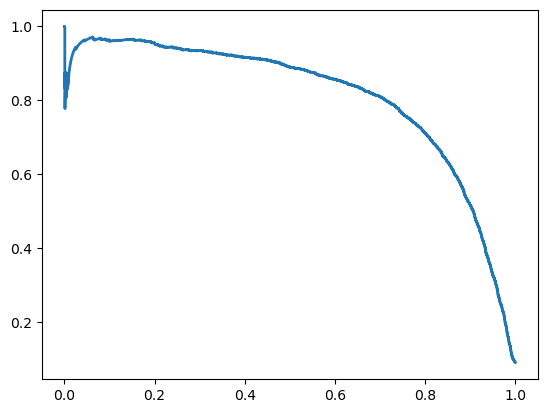

In [24]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

You can see that precision really starts to fall sharply at around 80%
recall. You will probably want to select a precision/recall trade-off just
before that drop—for example, at around 60% recall. But of course, the
choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot
to find the threshold you need to use, but that’s not very precise.

Alternatively, you can search for the lowest threshold that gives you at
least 90% precision. For this, you can use the NumPy array’s `argmax()`
method. This returns the first index of the maximum value, which in this
case means the first True value:

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the
classifier’s `predict()` method, you can run this code:

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let’s check these predictions’ precision and recall:

In [27]:
print( precision_score(y_train_5, y_train_pred_90) )
print( recall_score(y_train_5, y_train_pred_90) )

0.9000345901072293
0.4799852425751706


Great, you have a 90% precision classifier! As you can see, it is fairly
easy to create a classifier with virtually any precision you want: just set a
high enough threshold, and you’re done. But wait, not so fast–a high precision
classifier is not very useful if its recall is too low! 
For many applications, 48% recall wouldn’t be great at all.

If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”

# The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. It is very similar to the precision/recall curve,
but instead of plotting precision versus recall, the ROC curve plots the
true positive rate (another name for recall) against the false positive rate
(FPR). 

The FPR (also called the fall-out) is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true
negative rate (TNR), which is the ratio of negative instances that are
correctly classified as negative. The TNR is also called *specificity*. 

Hence, the ROC curve plots *sensitivity* (recall) versus 1 – *specificity*.
To plot the ROC curve, you first use the `roc_curve()` function to
compute the TPR and FPR for various threshold values:

In [28]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

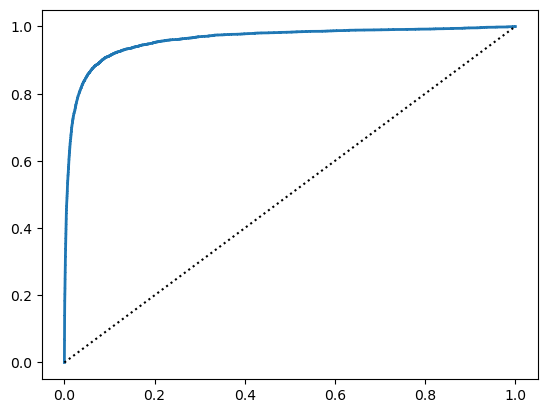

In [29]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false
positives (FPR) the classifier produces. The dotted line represents the
ROC curve of a purely random classifier; a good classifier stays as far
away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn
provides a function to estimate the ROC AUC:

In [30]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Classifier Comparision

Let’s now create a `RandomForestClassifier`, whose PR curve and F
score we can compare to those of the `SGDClassifier`:

In [31]:
forest_clf = RandomForestClassifier(random_state=42)

The `precision_recall_curve()` function expects labels and scores
for each instance, so we need to train the random forest classifier and
make it assign a score to each instance. 

But the `RandomForestClassifier` class does not have a
`decision_function()` method, due to the way it works (we will cover this in Chapter 7). Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. 

We can call the `cross_val_predict()` function to train the
RandomForestClassifier using cross-validation and make it predict
class probabilities for every image as follows:

In [32]:
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, 
                                    cv=3, method="predict_proba")

Let’s look at the class probabilities for the first two images in the training
set:

In [33]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability,
and it predicts that the second image is negative with 99% probability.

Since each image is either positive or negative, the probabilities in each
row add up to 100%.

The **second** column contains the estimated probabilities for the positive
class, so let’s pass them to the precision_recall_curve() function:

In [34]:
y_scores_forest = y_probas_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = \
      precision_recall_curve(y_train_5, y_scores_forest)

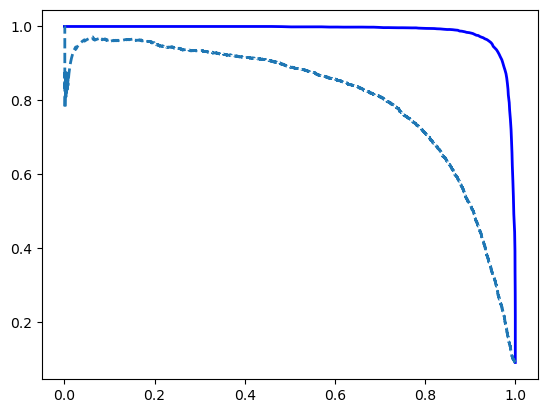

In [35]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

As you can see, the RandomForestClassifier’s PR curve looks much better than the SGDClassifier’s: it comes much closer to the top-right corner. Its F score and ROC AUC score are also significantly better:

In [36]:
y_pred_forest = y_probas_forest[:, 1] >= 0.5
print( f1_score(y_train_5, y_pred_forest) )
print( roc_auc_score(y_train_5, y_scores_forest) )

0.9274509803921569
0.9983436731328145


Try measuring the precision and recall scores: you should find about
99.1% precision and 86.6% recall. Not too bad!

You now know how to train binary classifiers, choose the appropriate
metric for your task, evaluate your classifiers using cross-validation,
select the precision/recall trade-off that fits your needs, and use several
metrics and curves to compare various models. You’re ready to try to
detect more than just the 5s.

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass
classifiers (also called multinomial classifiers) can distinguish between
more than two classes.

One way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a
0-detector, a 1-detector, a 2-detector, and so on). Then when you want to
classify an image, you get the decision score from each classifier for that
image and you select the class whose classifier outputs the highest score.
This is called the one-versus-the-rest (OvR) strategy, or sometimes oneversus-
all (OvA).

Another strategy is to train a binary classifier for every pair of digits: one
to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s
and 2s, and so on. This is called the one-versus-one (OvO) strategy. If
there are N classes, you need to train N × (N – 1) / 2 classifiers. For the
MNIST problem, this means training 45 binary classifiers! When you want
to classify an image, you have to run the image through all 45 classifiers
and see which class wins the most duels. The main advantage of OvO is
that each classifier only needs to be trained on the part of the training set
containing the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale
poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training
sets than to train few classifiers on large training sets. For most binary
classification algorithms, however, OvR is preferred.



Scikit-Learn detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm. Let’s try this with a support vector machine
classifier using the `sklearn.svm.SVC` class. We’ll only
train on the first 2,000 images, or else it will take a very long time:

In [37]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [38]:
some_digit_scores = svm_clf.decision_function([X[0]])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5:

In [39]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In the case of MNIST, the index of
each class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class '5'), but in general you
won’t be so lucky; you will need to look up the class label like this:

In [40]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [41]:
svm_clf.classes_[class_id]

'5'

Training an `SGDClassifier` on a multiclass dataset and using it to make
predictions is just as easy:

In [42]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train[:10000], y_train[:10000])
sgd_clf.predict([X[0]])

array(['5'], dtype='<U1')

# Error Analysis

If this were a real project, you would now follow the steps in your machine
learning project checklist. You’d explore data
preparation options, try out multiple models, shortlist the best ones, finetune
their hyperparameters using GridSearchCV, and automate as
much as possible. 

Here, we will assume that you have found a promising
model and you want to find ways to improve it. One way to do this is to
analyze the types of errors it makes.

First, look at the confusion matrix. For this, you first need to make
predictions using the `cross_val_predict()` function; then you can
pass the labels and predictions to the `confusion_matrix()` function,
just like you did earlier. However, since there are now 10 classes instead
of 2, the confusion matrix will contain quite a lot of numbers, and it may
be hard to read.
A colored diagram of the confusion matrix is much easier to analyze. To
plot such a diagram, use the
`ConfusionMatrixDisplay.from_predictions()` function like this:

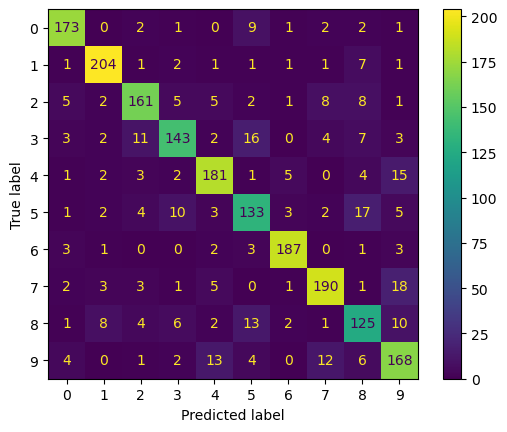

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train[:2000], y_train[:2000], cv=3)
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred)
plt.show()

This produces the left diagram in Figure 3-9. This confusion matrix looks
pretty good: most images are on the main diagonal, which means that
they were classified correctly. Notice that the cell on the diagonal in row
\#5 and column \#5 looks slightly darker than the other digits. This could be
because the model made more errors on 5s, or because there are fewer
5s in the dataset than the other digits. That’s why it’s important to
normalize the confusion matrix by dividing each value by the total number
of images in the corresponding (true) class (i.e., divide by the row’s sum).
This can be done simply by setting normalize="true". We can also
specify the values_format=".0%" argument to show percentages with
no decimals.

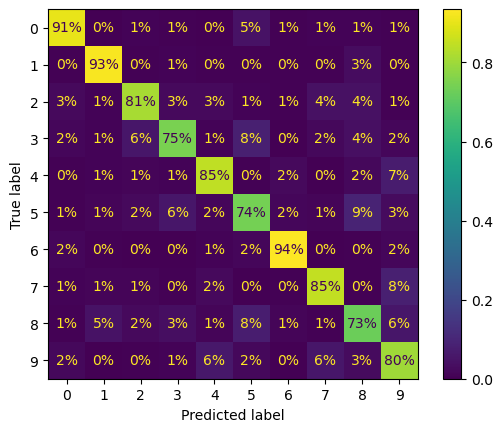

In [44]:
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred,normalize="true",values_format=".0%")
plt.show()

Now we can easily see that only 74% of the images of 5s were classified
correctly. The most common error the model made with images of 5s was
to misclassify them as 8s: this happened for 9% of all 5s. 

But only 8% of 8s got misclassified as 5s; confusion matrices are generally not
symmetrical! 

If you look carefully, you will notice that many digits have
been misclassified as 8s, but this is not immediately obvious from this
diagram. If you want to make the errors stand out more, you can try
putting zero weight on the correct predictions.

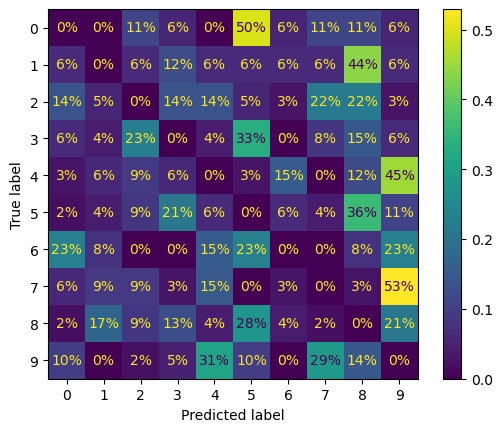

In [45]:
sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, 
                                        sample_weight=sample_weight,
                                        normalize="true",
                                        values_format=".0%")
plt.show()

Now you can see much more clearly the kinds of errors the classifier
makes. The column for class 8 is now really bright, which confirms that
many images got misclassified as 8s. In fact this is the most common
misclassification for almost all classes. But be careful how you interpret
the percentages in this diagram: remember that we’ve excluded the
correct predictions. For example, the 36% in row #7, column #9 does not
mean that 36% of all images of 7s were misclassified as 9s. It means that
36% of the errors the model made on images of 7s were
misclassifications as 9s. In reality, only 3% of images of 7s were
misclassified as 9s.


It is also possible to normalize the confusion matrix by column rather than
by row: you set `normalize="pred"`. For example, you can see that 56% of misclassified 7s are actually 9s.

Analyzing the confusion matrix often gives you insights into ways to
improve your classifier. Looking at these plots, it seems that your efforts
should be spent on reducing the false 8s. For example, you could try to
gather more training data for digits that look like 8s (but are not) so that
the classifier can learn to distinguish them from real 8s. Or you could
engineer new features that would help the classifier—for example, writing
an algorithm to count the number of closed loops (e.g., 8 has two, 6 has
one, 5 has none). Or you could preprocess the images (e.g., using ScikitImage,
Pillow, or OpenCV) to make some patterns, such as closed loops,
stand out more.

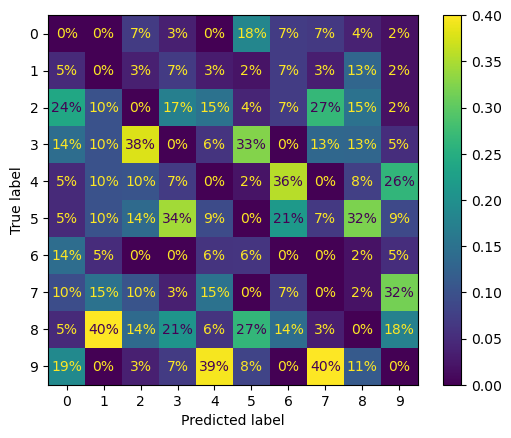

In [46]:
sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, 
                                        sample_weight=sample_weight,
                                        normalize="pred",
                                        values_format=".0%")
plt.show()